In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [3]:
# lattice and data directory
p0c = 43.36e6 # reference momentum in eV/c
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
data_dir = os.path.join('data', 'yaml_files')

In [4]:
# create gaussian and nongaussian beams using Bmad-X distgen functionality
gaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

nongaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

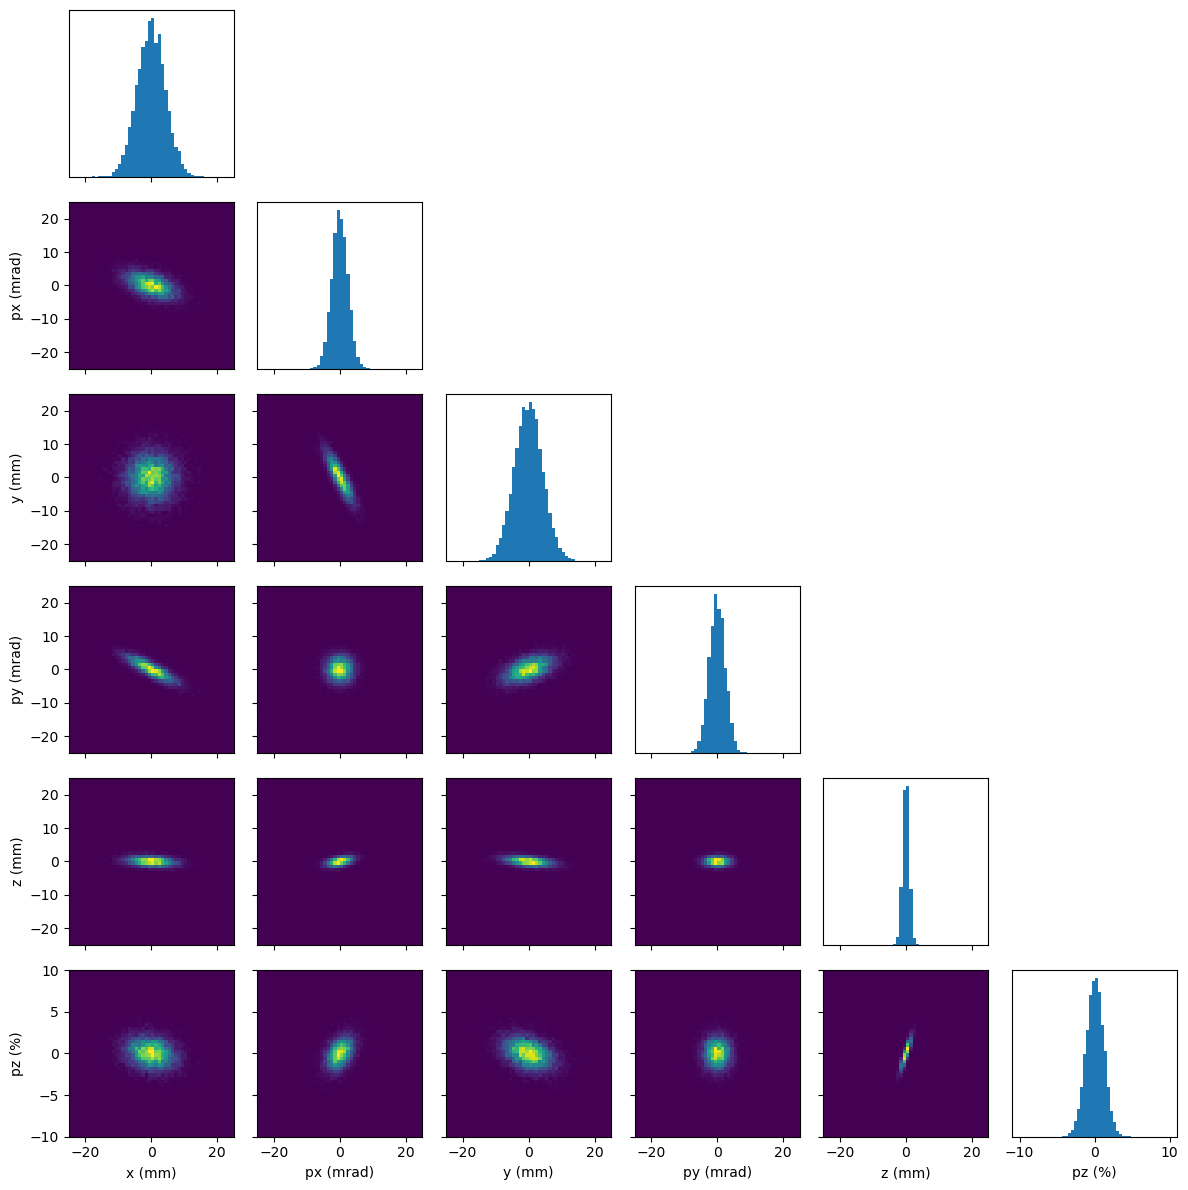

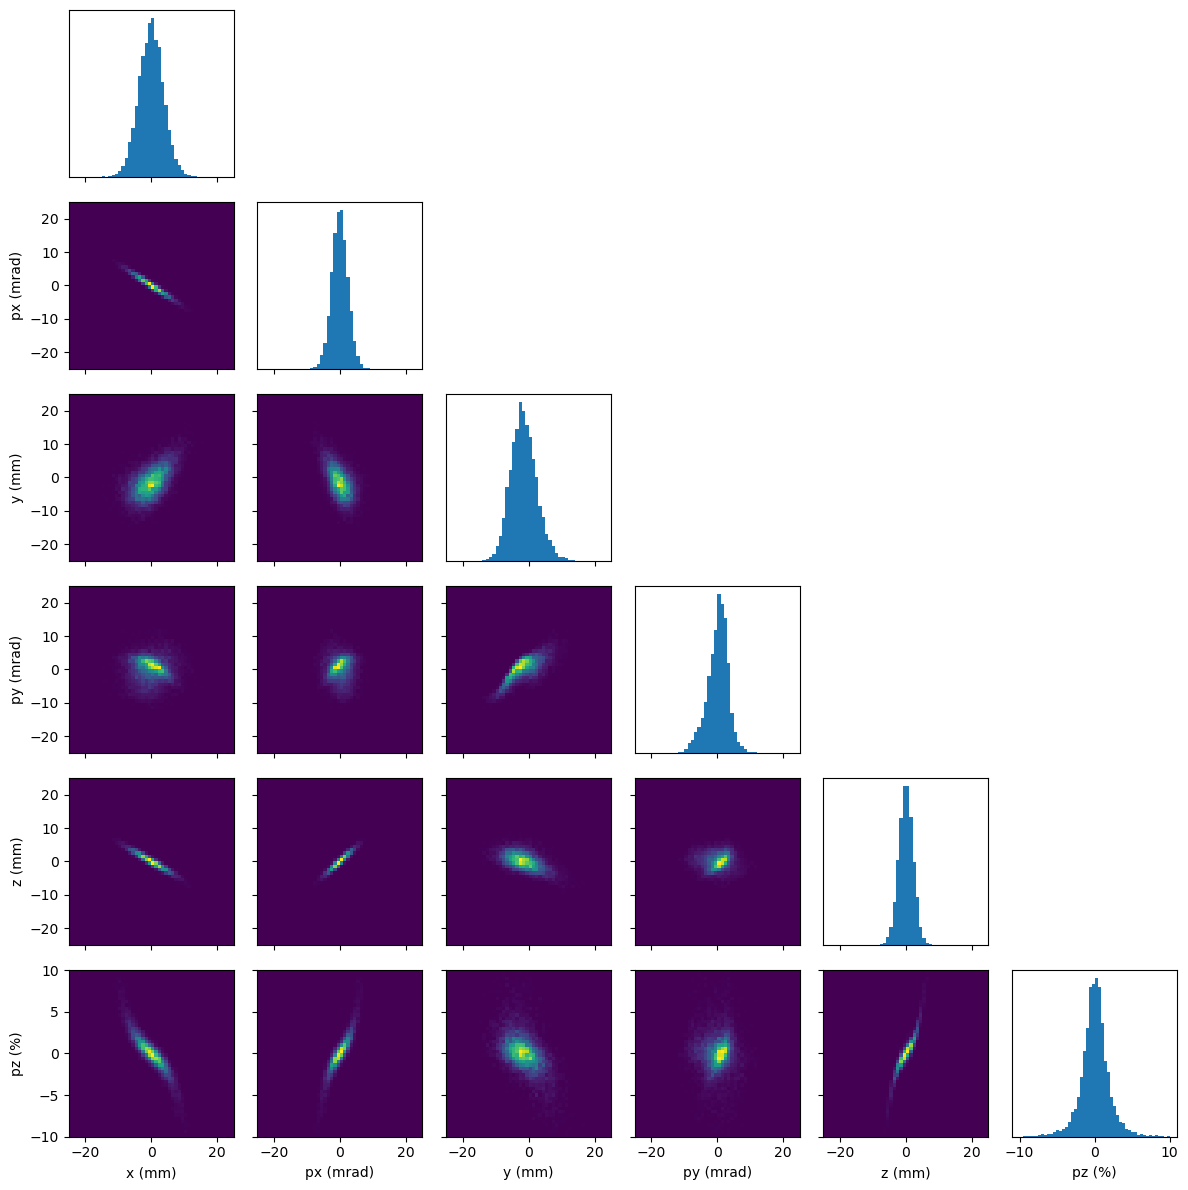

In [5]:
# plot linear and nonlinear beams
lims = np.array(
    [[-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-10e-2, 10e-2]]
    )
fig, ax = plot_projections(gaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(nongaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [6]:
# use xopt for optimization
from triplet_opt import optimize_function, output
from xopt import VOCS

opt_vocs = VOCS(
        variables = {"k1":[0,20], "k2":[-20,0], "k3":[0,20]},
        objectives = {"total_size": "MINIMIZE"}
    )

opt_gaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': gaussian_beam,
        'lattice': lattice
    }
)

opt_nongaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': nongaussian_beam,
        'lattice': lattice
    }
)

/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# optimization results for linear beam
opt_gaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
1,10.469624,-7.034340,9.321136,0.014345,0.035551,0.037038,0.018970,False
2,9.957081,-11.254451,9.862747,0.016676,0.018947,0.023829,0.012910,False
3,19.353990,-4.580866,17.858438,0.005659,0.115427,0.114522,0.012761,False
4,6.139778,-13.362645,6.490385,0.016155,0.003028,0.015291,0.037302,False
5,10.802058,-15.534925,4.062624,0.032048,0.014057,0.033682,0.036907,False
...,...,...,...,...,...,...,...,...
99,0.213064,-3.316867,19.391044,0.012745,0.041397,0.042070,0.013737,False
100,4.484689,-14.210377,14.579600,0.007580,0.012226,0.013013,0.013757,False
101,6.650572,-1.978685,3.731992,0.012590,0.028195,0.029561,0.013351,False
102,17.176180,-18.243723,8.022023,0.044586,0.015034,0.045790,0.013295,False


In [8]:
opt_gaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1    1.0162
k2     -20.0
k3      20.0
Name: 103, dtype: object

In [9]:
# optimization results for nonlinear beam
opt_nongaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
1,10.936913,-3.907227,14.908129,0.003219,0.076147,0.075179,0.014696,False
2,1.129450,-7.025078,16.325781,0.005437,0.035345,0.034630,0.013352,False
3,4.447606,-7.022566,18.271131,0.003721,0.050525,0.049599,0.013409,False
4,0.000000,-11.822430,13.817607,0.004767,0.014431,0.013949,0.013352,False
5,0.000000,-17.318267,12.116573,0.004195,0.005128,0.005220,0.013535,False
...,...,...,...,...,...,...,...,...
99,16.286385,-7.457882,7.270308,0.026147,0.039751,0.046196,0.013522,False
100,7.408602,-1.054316,1.073426,0.016664,0.027733,0.030984,0.013033,False
101,17.750406,-1.374878,5.289321,0.021278,0.066667,0.068727,0.013184,False
102,8.479871,-8.119342,5.033889,0.019750,0.016953,0.024618,0.013692,False


In [10]:
opt_nongaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1          0.0
k2   -15.829916
k3    11.722394
Name: 103, dtype: object